# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band11.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1        2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.96449 -0.844843 -0.965204 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.96449 -0.844843 -0.965204 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.96449 -0.844843 -0.965204 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.96449 -0.844843 -0.965204 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.96449 -0.844843 -0.965204 -1.0 -1.0 -1.0 -1.0   

                   9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.885546   
      201547 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.885546   
      201548 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.885546   
      201549 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.885546   
      201550 -0.9543  ...  -1.0 -0.933497 -0.919513  -1.0  -1.0 -0.885546   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.945283  -1.0 -0.861740  
      201547  -1.0 -0.945283  -1.0 -0.854589  
      201548  -1.0 -0.945283  -1.0 -0.856973  
      201549  -1.0 -0.945283  -1.0 -0.856973  
      201550  -1.0 -0.945283  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5         6  \
5360 201546 -1.0 -1.000000 -0.964490 -0.844843 -0.965204 -1.0 -1.000000   
     201547 -1.0 -1.000000 -0.525201 -1.000000 -0.995617 -1.0 -1.000000   
     201548 -1.0 -1.000000 -0.964490 -0.844843 -0.965204 -1.0 -1.000000   
     201549 -1.0 -0.692039 -0.691831 -1.000000 -1.000000 -1.0 -0.942319   
     201550 -1.0 -1.000000 -0.964490 -0.844843 -0.965204 -1.0 -1.000000   

                    7         8         9  ...  2039      2040      2041  \
5360 201546 -1.000000 -1.000000 -0.954300  ...  -1.0 -0.933497 -0.919513   
     201547 -1.000000 -1.000000 -0.999539  ...  -1.0 -0.943656 -1.000000   
     201548 -1.000000 -1.000000 -0.954300  ...  -1.0 -0.933497 -0.919513   
     201549 -0.876445 -0.953343 -0.285192  ...  -1.0 -0.856660 -1.000000   
     201550 -1.000000 -1.000000 -0.954300  ...  -1.0 -0.933497 -0.919513   

             2042      2043      2044  2045      2046      2047    Labels  
5360 201546  -1.0 -1.000000 -0.885546  -1.0 -0.945283 -1.000000 -0.990465  
     201547  -1.0 -0.996475 -1.000000  -1.0 -0.748040 -1.000000 -0.969011  
     201548  -1.0 -1.000000 -0.885546  -1.0 -0.945283 -1.000000 -0.995232  
     201549  -1.0 -0.866080 -0.812552  -1.0 -0.536021 -0.945839 -0.997616  
     201550  -1.0 -1.000000 -0.885546  -1.0 -0.945283 -1.000000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

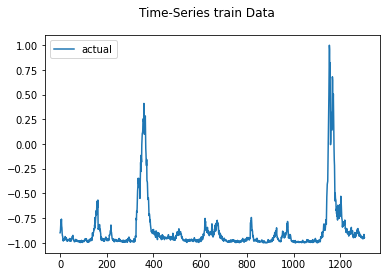

2023-03-06 15:18:24.703065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:18:24.703256: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:18:24.703432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 15:18:24.703854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:18:25.078530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 101.679
Test RMSE: 131.770
Test sMAPE: 145.709
Test R Squared: -14.982
{'mae': 101.67921731589031, 'rmse': 131.77034560329906, 'smape': 145.70905643788677, 'r2': -14.98165628767456}


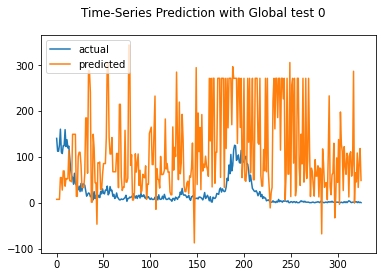

Test MAE: 58.085
Test RMSE: 70.378
Test sMAPE: 150.635
Test R Squared: -3.559
{'mae': 58.085327010944575, 'rmse': 70.37760625193137, 'smape': 150.6345006662956, 'r2': -3.55885100388615}


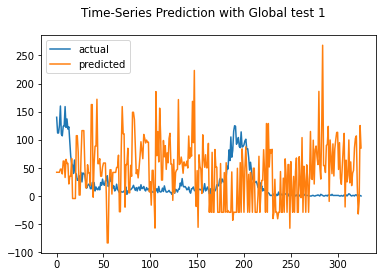

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 52.727
Test RMSE: 72.253
Test sMAPE: 143.585
Test R Squared: -3.805
{'mae': 52.726899302810246, 'rmse': 72.25300595942362, 'smape': 143.58539901251575, 'r2': -3.8050538145065715}


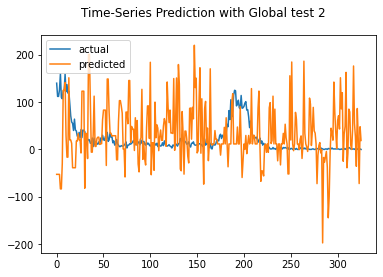

Test MAE: 51.666
Test RMSE: 64.111
Test sMAPE: 142.382
Test R Squared: -2.783
{'mae': 51.665867103023764, 'rmse': 64.11144362395036, 'smape': 142.3824889542263, 'r2': -2.783184560156652}


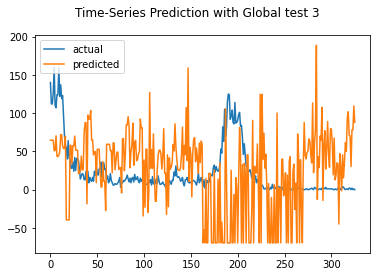

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 41.893
Test RMSE: 49.654
Test sMAPE: 131.994
Test R Squared: -1.269
{'mae': 41.89318663576629, 'rmse': 49.65357756294529, 'smape': 131.99418968067627, 'r2': -1.269276973618633}


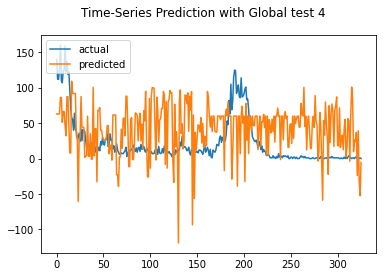

Test MAE: 77.913
Test RMSE: 97.227
Test sMAPE: 142.343
Test R Squared: -7.701
{'mae': 77.91304021964044, 'rmse': 97.22695530936191, 'smape': 142.34267046076528, 'r2': -7.700812063023262}


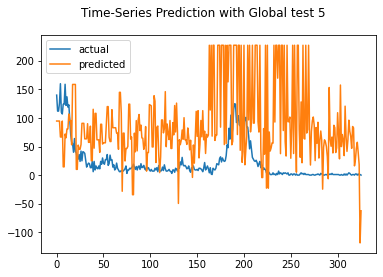

Test MAE: 71.672
Test RMSE: 78.667
Test sMAPE: 140.852
Test R Squared: -4.696
{'mae': 71.67188930804012, 'rmse': 78.66722503706323, 'smape': 140.85201976721277, 'r2': -4.696053737784881}


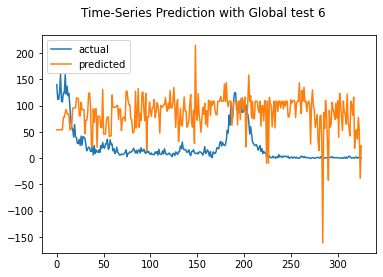

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 49.352
Test RMSE: 59.725
Test sMAPE: 135.399
Test R Squared: -2.283
{'mae': 49.35232513082539, 'rmse': 59.725049188474465, 'smape': 135.39900420355116, 'r2': -2.2832159461447286}


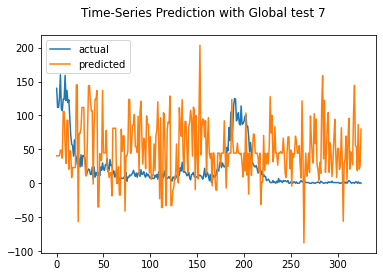

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 48.127
Test RMSE: 58.335
Test sMAPE: 144.665
Test R Squared: -2.132
{'mae': 48.12662590299647, 'rmse': 58.33500033781059, 'smape': 144.66503904001, 'r2': -2.132166394581972}


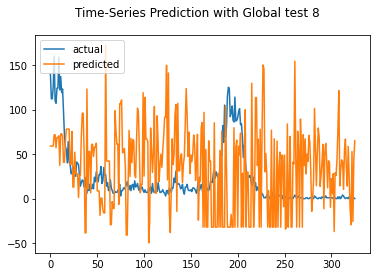

Test MAE: 62.473
Test RMSE: 70.947
Test sMAPE: 136.874
Test R Squared: -3.633
{'mae': 62.47287736430856, 'rmse': 70.94667283844075, 'smape': 136.8743170445243, 'r2': -3.6328739355345014}


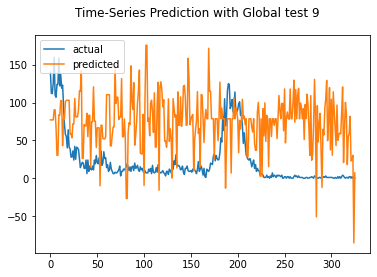

Test MAE: 47.063
Test RMSE: 54.085
Test sMAPE: 130.517
Test R Squared: -1.692
{'mae': 47.063242165040386, 'rmse': 54.08543463265545, 'smape': 130.51745249127893, 'r2': -1.6924463877526152}


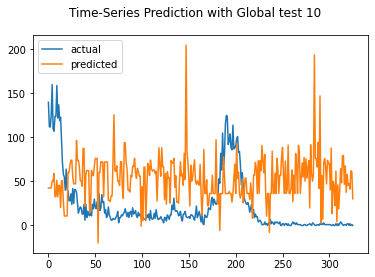

Test MAE: 57.941
Test RMSE: 64.547
Test sMAPE: 136.411
Test R Squared: -2.835
{'mae': 57.94137379947615, 'rmse': 64.54655664844155, 'smape': 136.41142133301238, 'r2': -2.834710425781714}


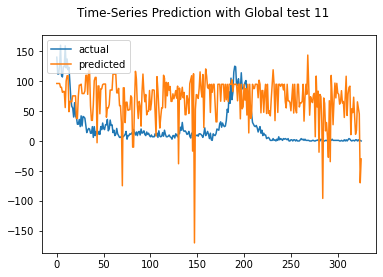

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 56.098
Test RMSE: 68.299
Test sMAPE: 132.245
Test R Squared: -3.294
{'mae': 56.09789428754818, 'rmse': 68.29938320786731, 'smape': 132.2451453439023, 'r2': -3.29358415567295}


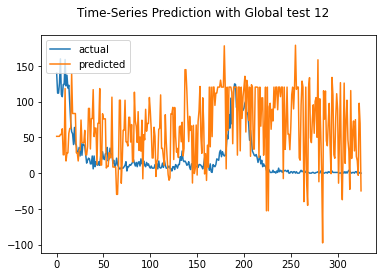

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 62.110
Test RMSE: 75.993
Test sMAPE: 160.059
Test R Squared: -4.315
{'mae': 62.10964146603836, 'rmse': 75.99282258633191, 'smape': 160.05943850505523, 'r2': -4.315346338795946}


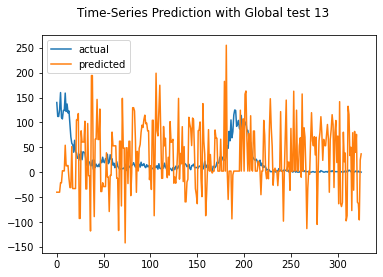

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.031
Test RMSE: 59.807
Test sMAPE: 137.522
Test R Squared: -2.292
{'mae': 50.0310135791821, 'rmse': 59.80731586903385, 'smape': 137.5216400059033, 'r2': -2.292266932344141}


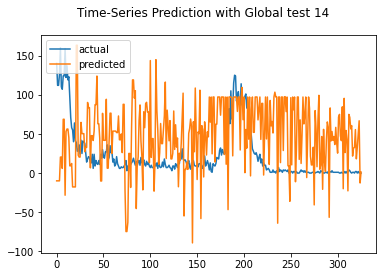

Test MAE: 67.906
Test RMSE: 86.061
Test sMAPE: 145.543
Test R Squared: -5.817
{'mae': 67.90597521298868, 'rmse': 86.061429870096, 'smape': 145.54328584183733, 'r2': -5.817160689619378}


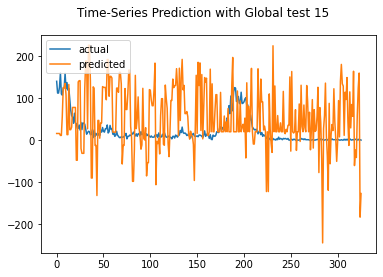

Test MAE: 64.799
Test RMSE: 87.762
Test sMAPE: 155.158
Test R Squared: -6.089
{'mae': 64.79879905310877, 'rmse': 87.76160022693114, 'smape': 155.1576956432522, 'r2': -6.089171505021525}


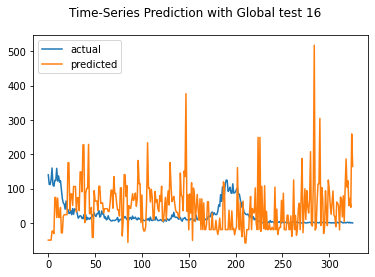

Test MAE: 84.244
Test RMSE: 97.021
Test sMAPE: 155.735
Test R Squared: -7.664
{'mae': 84.24397243312531, 'rmse': 97.02051881916935, 'smape': 155.73530503980058, 'r2': -7.663903404296592}


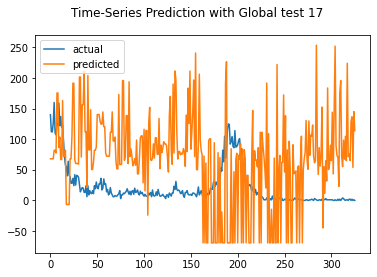

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 49.804
Test RMSE: 60.940
Test sMAPE: 130.289
Test R Squared: -2.418
{'mae': 49.80377978068188, 'rmse': 60.940143117134284, 'smape': 130.28854580459824, 'r2': -2.418167620254106}


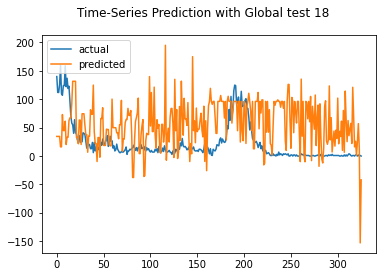

Test MAE: 58.310
Test RMSE: 68.716
Test sMAPE: 135.714
Test R Squared: -3.346
{'mae': 58.31012054820734, 'rmse': 68.71612445863458, 'smape': 135.71435186440354, 'r2': -3.3461401952783474}


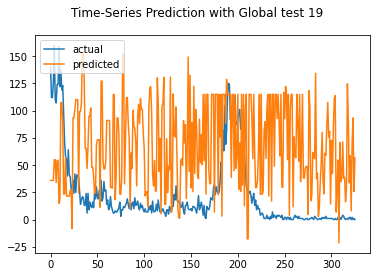

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.960
Test RMSE: 55.573
Test sMAPE: 129.142
Test R Squared: -1.843
{'mae': 46.95967405522528, 'rmse': 55.573173682545026, 'smape': 129.14206595058414, 'r2': -1.8426069578919857}


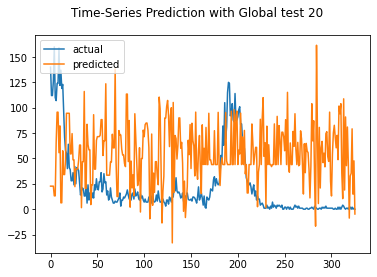

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.677
Test RMSE: 55.066
Test sMAPE: 128.459
Test R Squared: -1.791
{'mae': 45.677205823864675, 'rmse': 55.06646702904722, 'smape': 128.45920403058213, 'r2': -1.7910064733254787}


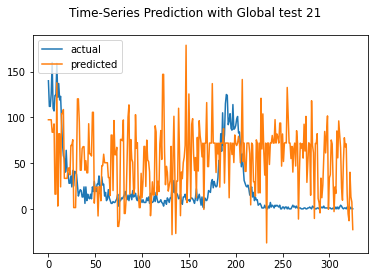

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 55.680
Test RMSE: 67.001
Test sMAPE: 139.795
Test R Squared: -3.132
{'mae': 55.680185515090734, 'rmse': 67.00086810721487, 'smape': 139.79504119515533, 'r2': -3.1318759627339556}


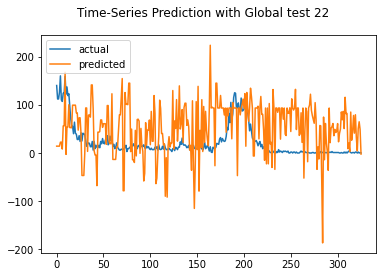

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 58.541
Test RMSE: 70.267
Test sMAPE: 138.671
Test R Squared: -3.545
{'mae': 58.54067886058538, 'rmse': 70.2672959171612, 'smape': 138.6706056412092, 'r2': -3.544571056276469}


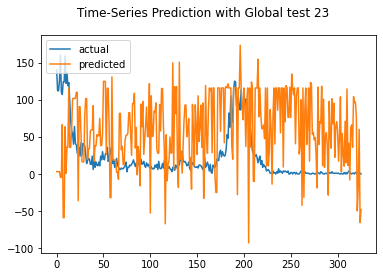

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 38.581
Test RMSE: 48.530
Test sMAPE: 132.500
Test R Squared: -1.168
{'mae': 38.58129448164826, 'rmse': 48.52954731037051, 'smape': 132.49953931035702, 'r2': -1.1676985972815257}


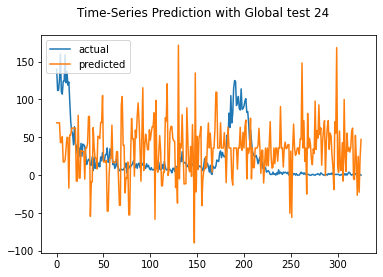

Test MAE: 49.129
Test RMSE: 61.879
Test sMAPE: 137.501
Test R Squared: -2.524
{'mae': 49.129453123712835, 'rmse': 61.87874414416106, 'smape': 137.50126087832015, 'r2': -2.524271826220188}


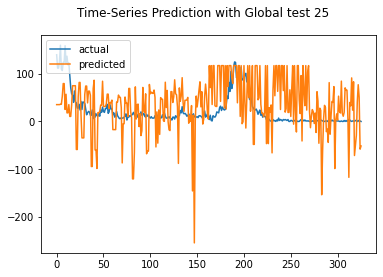

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 44.521
Test RMSE: 57.313
Test sMAPE: 135.684
Test R Squared: -2.023
{'mae': 44.52076167105897, 'rmse': 57.31276170747024, 'smape': 135.68424202906078, 'r2': -2.0233546087488294}


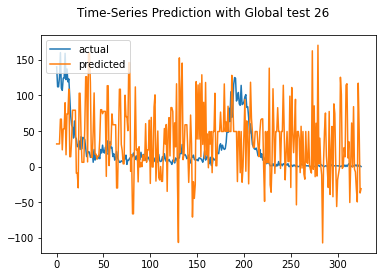

Test MAE: 69.229
Test RMSE: 83.912
Test sMAPE: 138.794
Test R Squared: -5.481
{'mae': 69.22941548107592, 'rmse': 83.9120720057258, 'smape': 138.79387702039807, 'r2': -5.480899791147079}


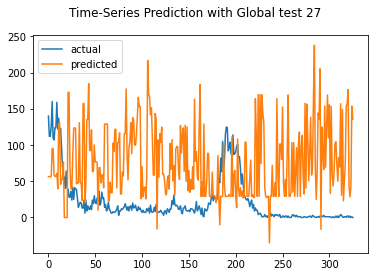

Test MAE: 53.320
Test RMSE: 61.431
Test sMAPE: 134.629
Test R Squared: -2.473
{'mae': 53.32044607181491, 'rmse': 61.4306892875421, 'smape': 134.62873787265258, 'r2': -2.473419138966431}


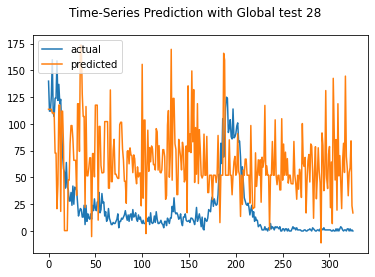

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 51.363
Test RMSE: 61.204
Test sMAPE: 127.180
Test R Squared: -2.448
{'mae': 51.36317000506114, 'rmse': 61.20440488710586, 'smape': 127.18023860485955, 'r2': -2.4478770860217365}


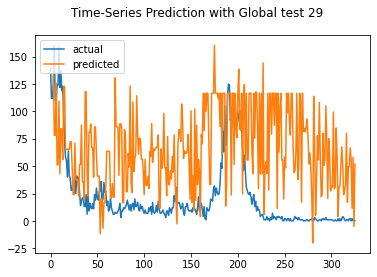

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 48.622
Test RMSE: 57.402
Test sMAPE: 130.974
Test R Squared: -2.033
{'mae': 48.62192299632938, 'rmse': 57.40182662746404, 'smape': 130.97436805977637, 'r2': -2.0327585898848692}


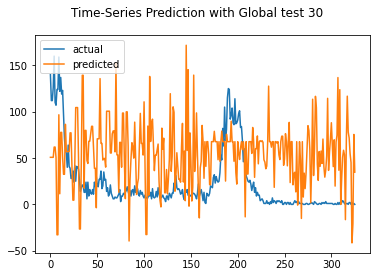

Test MAE: 112.263
Test RMSE: 172.240
Test sMAPE: 146.591
Test R Squared: -26.306
{'mae': 112.26288055514266, 'rmse': 172.23950359270972, 'smape': 146.590517181179, 'r2': -26.3056139928702}


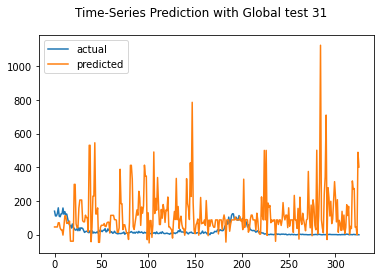

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 39.501
Test RMSE: 49.365
Test sMAPE: 130.071
Test R Squared: -1.243
{'mae': 39.500836484637, 'rmse': 49.3647500651142, 'smape': 130.07125144618388, 'r2': -1.2429536610243095}


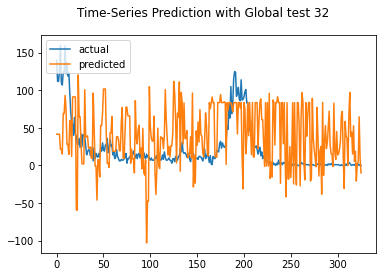

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 51.100
Test RMSE: 63.702
Test sMAPE: 143.266
Test R Squared: -2.735
{'mae': 51.10048616389555, 'rmse': 63.702156248821034, 'smape': 143.26601912171634, 'r2': -2.735035054598975}


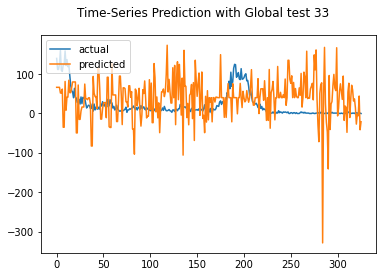

Test MAE: 48.255
Test RMSE: 66.426
Test sMAPE: 127.997
Test R Squared: -3.061
{'mae': 48.25509736069872, 'rmse': 66.42566057580197, 'smape': 127.9972469062059, 'r2': -3.0612355598851932}


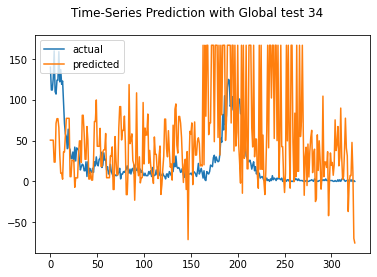

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.494
Test RMSE: 61.623
Test sMAPE: 130.218
Test R Squared: -2.495
{'mae': 47.49362782100958, 'rmse': 61.62308560974756, 'smape': 130.21817828424676, 'r2': -2.4952101872584076}


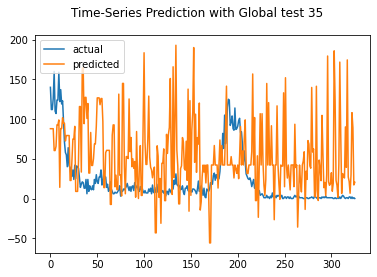

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 47.673
Test RMSE: 57.384
Test sMAPE: 133.560
Test R Squared: -2.031
{'mae': 47.673445258221015, 'rmse': 57.38393478665903, 'smape': 133.5600315561176, 'r2': -2.030868295427429}


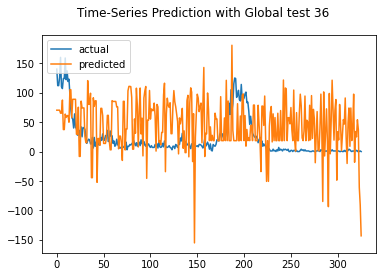

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 62.595
Test RMSE: 79.490
Test sMAPE: 144.701
Test R Squared: -4.816
{'mae': 62.595210428618216, 'rmse': 79.48971379555398, 'smape': 144.700949902163, 'r2': -4.815784194073414}


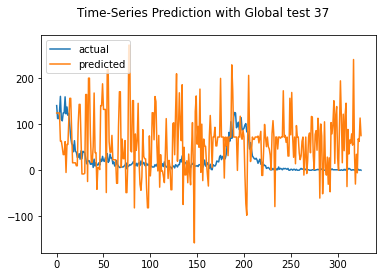

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 54.613
Test RMSE: 65.736
Test sMAPE: 140.004
Test R Squared: -2.977
{'mae': 54.612772848708495, 'rmse': 65.7364445381723, 'smape': 140.00436694792282, 'r2': -2.9773960485243953}


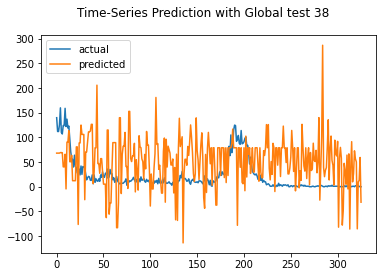

Test MAE: 101.560
Test RMSE: 118.370
Test sMAPE: 146.896
Test R Squared: -11.896
{'mae': 101.56005771759828, 'rmse': 118.37004006511377, 'smape': 146.89558677000636, 'r2': -11.896444854669573}


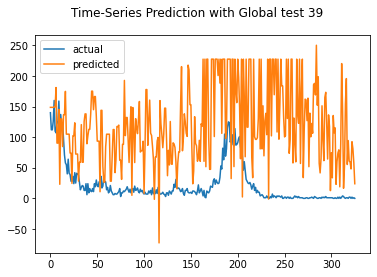

Test MAE: 103.752
Test RMSE: 121.057
Test sMAPE: 155.919
Test R Squared: -12.489
{'mae': 103.75222081019103, 'rmse': 121.05697677333194, 'smape': 155.91851563008186, 'r2': -12.488574775943926}


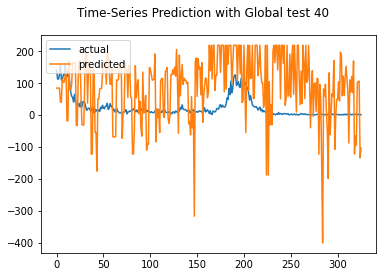

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 45.934
Test RMSE: 56.988
Test sMAPE: 129.578
Test R Squared: -1.989
{'mae': 45.93400326298058, 'rmse': 56.98829982001255, 'smape': 129.57760892984592, 'r2': -1.9892195723564585}


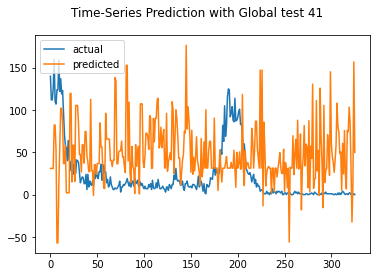

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 54.877
Test RMSE: 68.914
Test sMAPE: 151.089
Test R Squared: -3.371
{'mae': 54.87701005676041, 'rmse': 68.91447651771145, 'smape': 151.0886158364722, 'r2': -3.371267050400723}


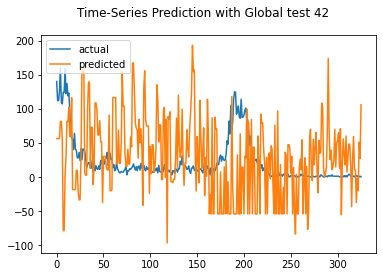

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 67.675
Test RMSE: 81.739
Test sMAPE: 137.632
Test R Squared: -5.150
{'mae': 67.6746551562672, 'rmse': 81.73915891112541, 'smape': 137.6321137431227, 'r2': -5.149598261775807}


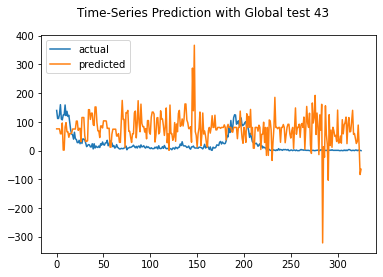

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 55.574
Test RMSE: 68.657
Test sMAPE: 133.105
Test R Squared: -3.339
{'mae': 55.57363084050044, 'rmse': 68.65665830513538, 'smape': 133.1048207015613, 'r2': -3.338621249385189}


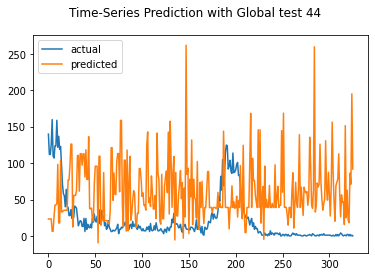

Test MAE: 76.005
Test RMSE: 88.781
Test sMAPE: 152.522
Test R Squared: -6.255
{'mae': 76.00524459477583, 'rmse': 88.78136051591271, 'smape': 152.52190501087094, 'r2': -6.254876239745768}


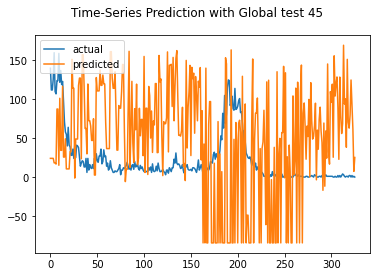

Test MAE: 53.448
Test RMSE: 66.273
Test sMAPE: 133.151
Test R Squared: -3.043
{'mae': 53.4483655213944, 'rmse': 66.27334850638893, 'smape': 133.15094490610775, 'r2': -3.042632327343436}


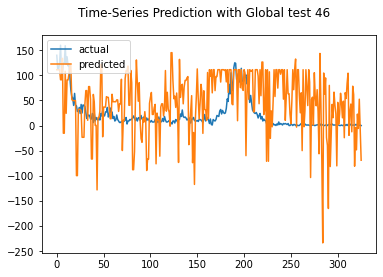

Test MAE: 101.896
Test RMSE: 140.803
Test sMAPE: 156.209
Test R Squared: -17.248
{'mae': 101.89622158982272, 'rmse': 140.8034093486685, 'smape': 156.20943890240702, 'r2': -17.24789434388858}


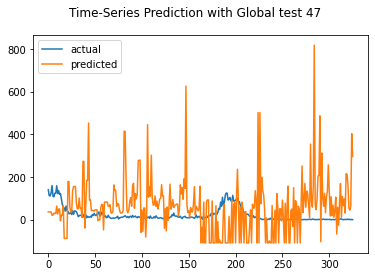

Test MAE: 81.035
Test RMSE: 100.332
Test sMAPE: 156.992
Test R Squared: -8.265
{'mae': 81.0349215265432, 'rmse': 100.33184967483817, 'smape': 156.99150142315764, 'r2': -8.265397453517025}


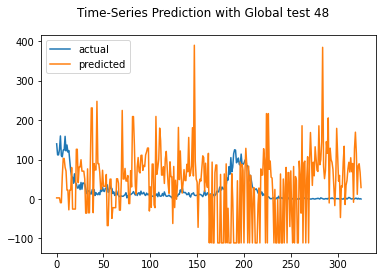

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 55.394
Test RMSE: 64.722
Test sMAPE: 155.158
Test R Squared: -2.856
{'mae': 55.39360750909963, 'rmse': 64.72235630087245, 'smape': 155.15806896705763, 'r2': -2.8556273838152033}


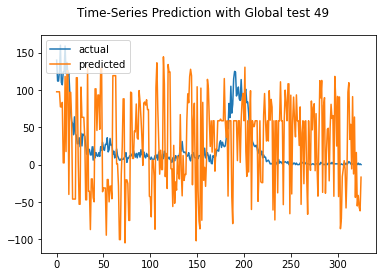

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.118
Test RMSE: 53.718
Test sMAPE: 129.582
Test R Squared: -1.656
{'mae': 46.118308700484, 'rmse': 53.71790961437413, 'smape': 129.582293784208, 'r2': -1.6559789241890241}


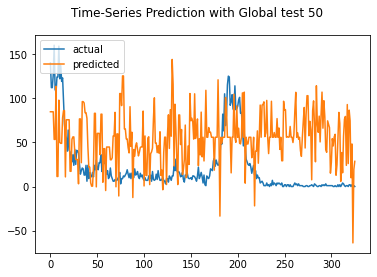

Test MAE: 51.046
Test RMSE: 59.360
Test sMAPE: 133.248
Test R Squared: -2.243
{'mae': 51.04577781963933, 'rmse': 59.36032092707044, 'smape': 133.24832927530989, 'r2': -2.2432385739590934}


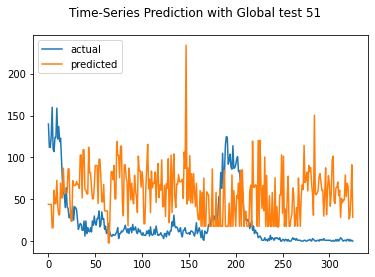

Test MAE: 94.827
Test RMSE: 130.918
Test sMAPE: 149.596
Test R Squared: -14.776
{'mae': 94.82716944192084, 'rmse': 130.9184882055396, 'smape': 149.59562980099088, 'r2': -14.775690575445429}


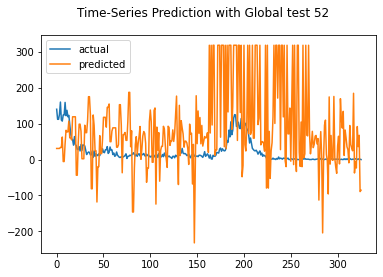

Test MAE: 83.110
Test RMSE: 97.931
Test sMAPE: 145.987
Test R Squared: -7.827
{'mae': 83.10992238912846, 'rmse': 97.93107219519315, 'smape': 145.98674890985373, 'r2': -7.82729082202769}


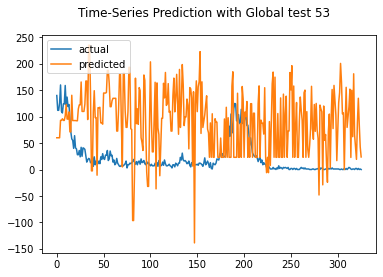

Test MAE: 57.585
Test RMSE: 74.382
Test sMAPE: 135.319
Test R Squared: -4.092
{'mae': 57.58496704880445, 'rmse': 74.38187039507, 'smape': 135.3194830313677, 'r2': -4.09237767984721}


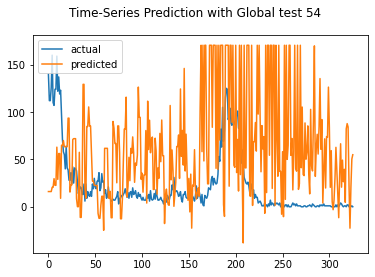

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 40.576
Test RMSE: 51.311
Test sMAPE: 126.064
Test R Squared: -1.423
{'mae': 40.57564533076769, 'rmse': 51.31091822276656, 'smape': 126.06387789066596, 'r2': -1.4232933431793309}


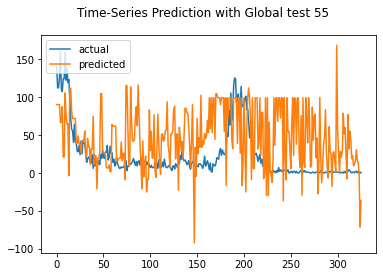

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 47.148
Test RMSE: 61.245
Test sMAPE: 143.416
Test R Squared: -2.452
{'mae': 47.14828088294509, 'rmse': 61.24534103714596, 'smape': 143.41633266869013, 'r2': -2.4524908067230244}


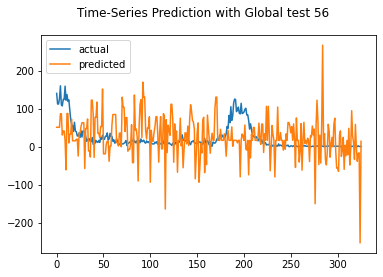

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 49.915
Test RMSE: 57.930
Test sMAPE: 130.975
Test R Squared: -2.089
{'mae': 49.91497296881091, 'rmse': 57.92966043807215, 'smape': 130.9746624056368, 'r2': -2.088789995020152}


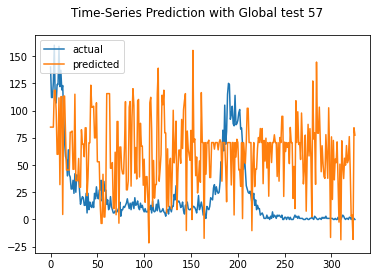

Test MAE: 68.583
Test RMSE: 76.790
Test sMAPE: 138.471
Test R Squared: -4.427
{'mae': 68.58300358020455, 'rmse': 76.79020014698054, 'smape': 138.47067937863193, 'r2': -4.427477294604048}


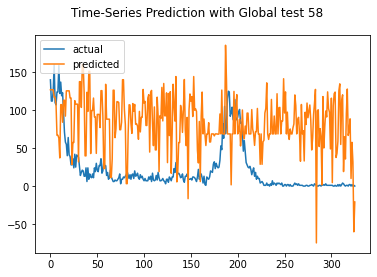

Test MAE: 57.740
Test RMSE: 78.096
Test sMAPE: 134.418
Test R Squared: -4.614
{'mae': 57.7401767775325, 'rmse': 78.09586426110667, 'smape': 134.4180091243277, 'r2': -4.613613231100792}


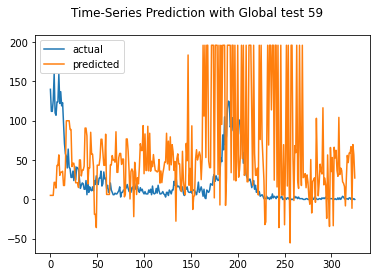

Test MAE: 57.267
Test RMSE: 71.263
Test sMAPE: 133.277
Test R Squared: -3.674
{'mae': 57.266548694277105, 'rmse': 71.26333232129676, 'smape': 133.2767202510872, 'r2': -3.67432245923126}


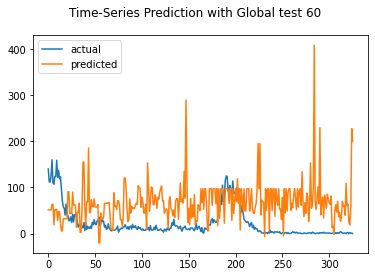

Test MAE: 62.258
Test RMSE: 78.061
Test sMAPE: 132.591
Test R Squared: -4.609
{'mae': 62.257560172969576, 'rmse': 78.06149575586014, 'smape': 132.59078686340183, 'r2': -4.608673429361781}


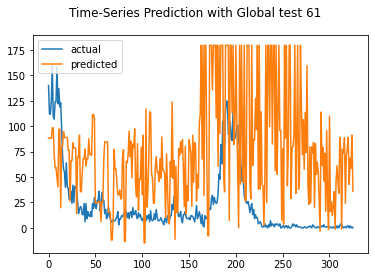

Test MAE: 59.541
Test RMSE: 74.274
Test sMAPE: 133.258
Test R Squared: -4.078
{'mae': 59.541026353470386, 'rmse': 74.27420194702097, 'smape': 133.25818915095724, 'r2': -4.077645821869388}


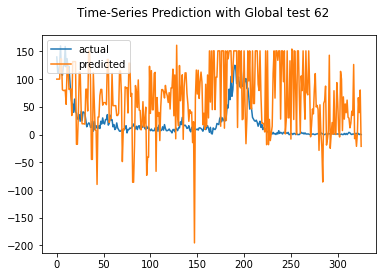

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 46.339
Test RMSE: 55.846
Test sMAPE: 129.529
Test R Squared: -1.871
{'mae': 46.339386505491895, 'rmse': 55.84580280619323, 'smape': 129.5286280861043, 'r2': -1.8705657128913495}


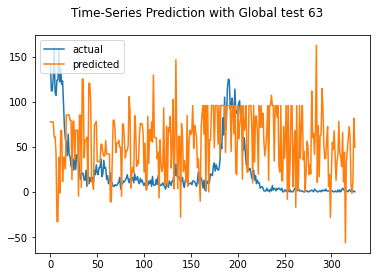

Test MAE: 43.632
Test RMSE: 49.206
Test sMAPE: 128.412
Test R Squared: -1.229
{'mae': 43.632493674755096, 'rmse': 49.206488201111675, 'smape': 128.41215866527455, 'r2': -1.228595034315422}


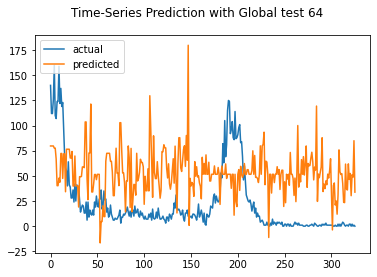

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.147
Test RMSE: 63.179
Test sMAPE: 135.171
Test R Squared: -2.674
{'mae': 50.147159155252524, 'rmse': 63.179261713413105, 'smape': 135.17057363360115, 'r2': -2.67396918543918}


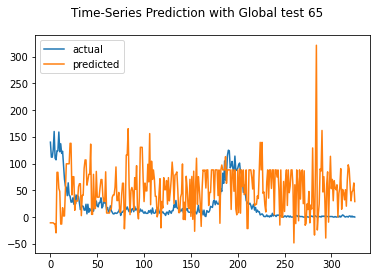

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 49.677
Test RMSE: 64.923
Test sMAPE: 138.679
Test R Squared: -2.880
{'mae': 49.67704934759374, 'rmse': 64.92299467662579, 'smape': 138.679007280653, 'r2': -2.8795692151728565}


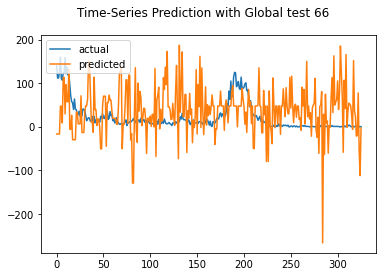

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.833
Test RMSE: 61.344
Test sMAPE: 137.697
Test R Squared: -2.464
{'mae': 47.8329722261502, 'rmse': 61.34446029055606, 'smape': 137.69680445995633, 'r2': -2.4636748484723654}


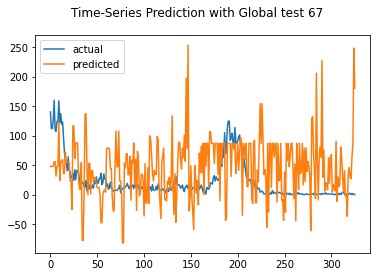

Test MAE: 47.227
Test RMSE: 53.121
Test sMAPE: 132.742
Test R Squared: -1.597
{'mae': 47.22719228011699, 'rmse': 53.12143738584184, 'smape': 132.74230145195133, 'r2': -1.5973235419765803}


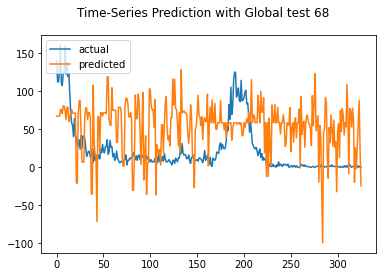

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 44.263
Test RMSE: 52.124
Test sMAPE: 129.362
Test R Squared: -1.501
{'mae': 44.26338062293691, 'rmse': 52.12371075820092, 'smape': 129.36184303713955, 'r2': -1.5006739415378902}


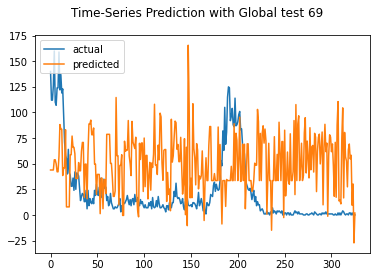

Test MAE: 76.269
Test RMSE: 99.716
Test sMAPE: 142.289
Test R Squared: -8.152
{'mae': 76.26921383003516, 'rmse': 99.71619171972338, 'smape': 142.288612152132, 'r2': -8.15203735480502}


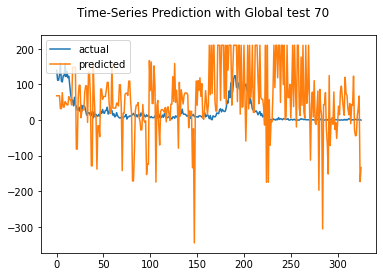

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 54.597
Test RMSE: 64.971
Test sMAPE: 134.081
Test R Squared: -2.885
{'mae': 54.59711290521125, 'rmse': 64.97058451162421, 'smape': 134.08101878667705, 'r2': -2.8852589011689624}


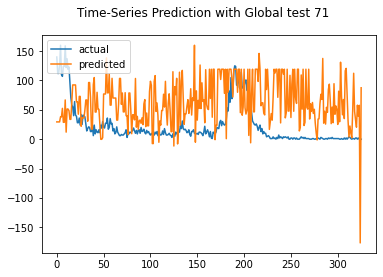

Test MAE: 72.809
Test RMSE: 102.709
Test sMAPE: 150.190
Test R Squared: -8.710
{'mae': 72.80927413098651, 'rmse': 102.70934410785766, 'smape': 150.19030667580466, 'r2': -8.70971154084333}


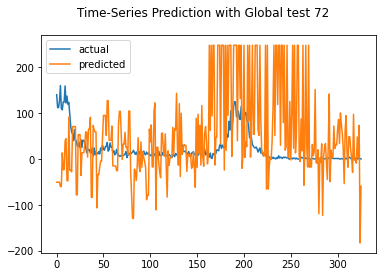

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 50.847
Test RMSE: 60.359
Test sMAPE: 139.814
Test R Squared: -2.353
{'mae': 50.84689064259909, 'rmse': 60.359250417109834, 'smape': 139.8142027096565, 'r2': -2.3533129934593724}


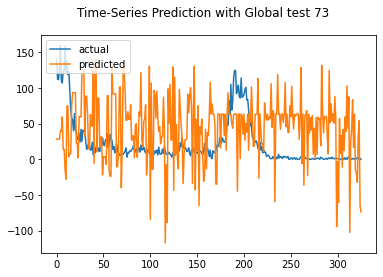

Test MAE: 104.373
Test RMSE: 135.873
Test sMAPE: 150.487
Test R Squared: -15.992
{'mae': 104.37253335429115, 'rmse': 135.8727135656213, 'smape': 150.48724066662245, 'r2': -15.992250980784782}


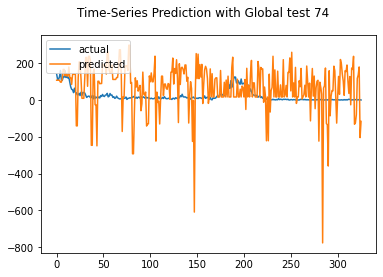

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 43.927
Test RMSE: 52.404
Test sMAPE: 129.006
Test R Squared: -1.528
{'mae': 43.926687840303764, 'rmse': 52.40417154106654, 'smape': 129.00577998439596, 'r2': -1.5276569711518708}


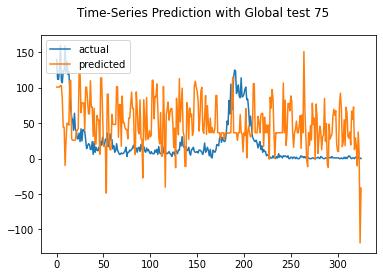

Test MAE: 131.896
Test RMSE: 185.691
Test sMAPE: 159.482
Test R Squared: -30.737
{'mae': 131.8958176166002, 'rmse': 185.69064358101133, 'smape': 159.48164887430258, 'r2': -30.7370429136666}


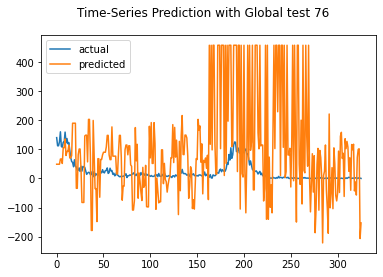

Test MAE: 56.334
Test RMSE: 69.169
Test sMAPE: 132.448
Test R Squared: -3.404
{'mae': 56.33398335477326, 'rmse': 69.1686032888899, 'smape': 132.44796631676067, 'r2': -3.403565174563238}


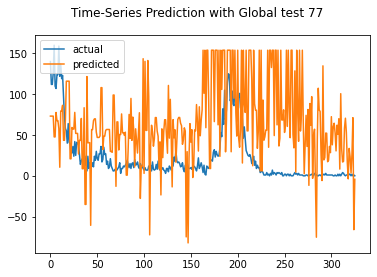

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 67.123
Test RMSE: 84.414
Test sMAPE: 138.879
Test R Squared: -5.559
{'mae': 67.12275163628206, 'rmse': 84.41405450378909, 'smape': 138.8790203746453, 'r2': -5.5586723738291965}


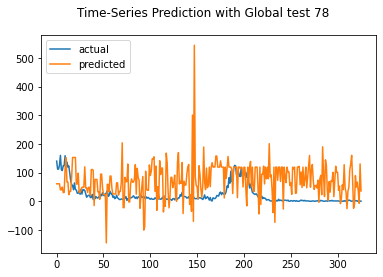

Test MAE: 85.551
Test RMSE: 126.834
Test sMAPE: 142.560
Test R Squared: -13.807
{'mae': 85.55080482619671, 'rmse': 126.83423226443875, 'smape': 142.55957246830997, 'r2': -13.806737772325793}


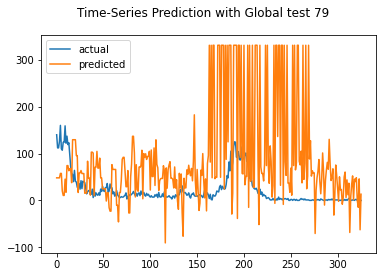

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 49.585
Test RMSE: 59.395
Test sMAPE: 137.993
Test R Squared: -2.247
{'mae': 49.58516293654412, 'rmse': 59.39519914584749, 'smape': 137.99329688734554, 'r2': -2.2470509393616744}


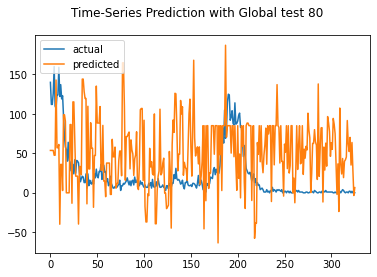

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 41.693
Test RMSE: 49.878
Test sMAPE: 134.931
Test R Squared: -1.290
{'mae': 41.69270431337181, 'rmse': 49.877685098214876, 'smape': 134.93125672257727, 'r2': -1.2898076089509867}


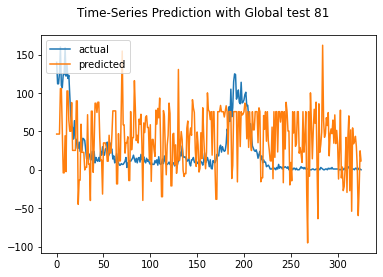

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 54.747
Test RMSE: 68.445
Test sMAPE: 145.567
Test R Squared: -3.312
{'mae': 54.746987953599245, 'rmse': 68.44523875622711, 'smape': 145.56690779030748, 'r2': -3.3119419130407834}


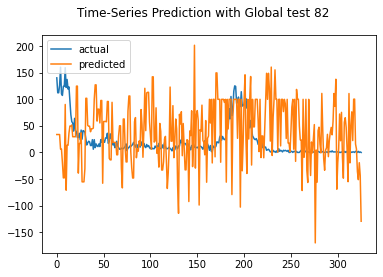

Test MAE: 86.564
Test RMSE: 130.454
Test sMAPE: 167.707
Test R Squared: -14.664
{'mae': 86.56412913819398, 'rmse': 130.45393863647385, 'smape': 167.7069404721579, 'r2': -14.663932671445743}


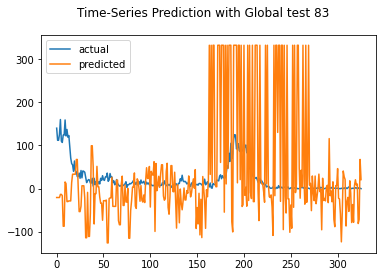

Test MAE: 104.746
Test RMSE: 138.334
Test sMAPE: 153.325
Test R Squared: -16.613
{'mae': 104.74603305921599, 'rmse': 138.33393901154636, 'smape': 153.32526512524976, 'r2': -16.613428599858512}


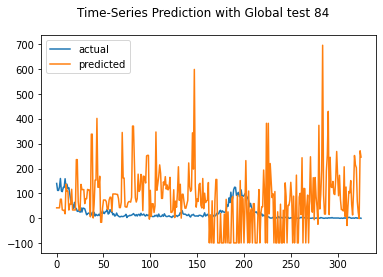

Test MAE: 88.015
Test RMSE: 102.625
Test sMAPE: 157.447
Test R Squared: -8.694
{'mae': 88.01500116572058, 'rmse': 102.62538917878017, 'smape': 157.44732265057326, 'r2': -8.693844533098126}


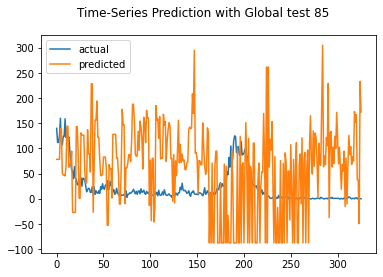

Test MAE: 48.716
Test RMSE: 60.133
Test sMAPE: 130.668
Test R Squared: -2.328
{'mae': 48.716419629158416, 'rmse': 60.132686366080605, 'smape': 130.66806993026466, 'r2': -2.3281862964484326}


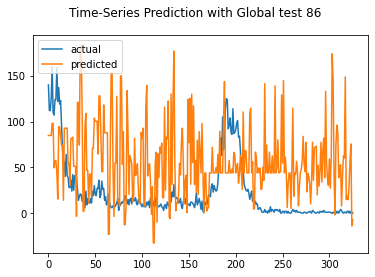

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 58.053
Test RMSE: 66.291
Test sMAPE: 138.229
Test R Squared: -3.045
{'mae': 58.05338617994742, 'rmse': 66.2910730167904, 'smape': 138.22872742052388, 'r2': -3.044794984341407}


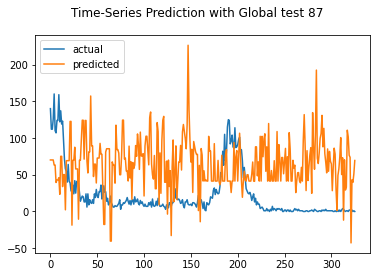

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 50.280
Test RMSE: 60.202
Test sMAPE: 131.822
Test R Squared: -2.336
{'mae': 50.28004342116461, 'rmse': 60.20155302622281, 'smape': 131.82245246165544, 'r2': -2.335813839274873}


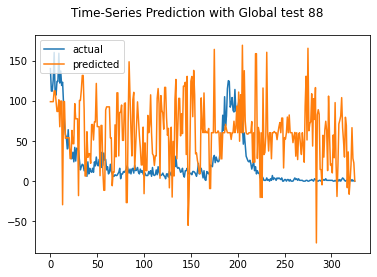

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 49.733
Test RMSE: 60.510
Test sMAPE: 133.032
Test R Squared: -2.370
{'mae': 49.73297342383788, 'rmse': 60.510004688388385, 'smape': 133.03195336367733, 'r2': -2.370084492727777}


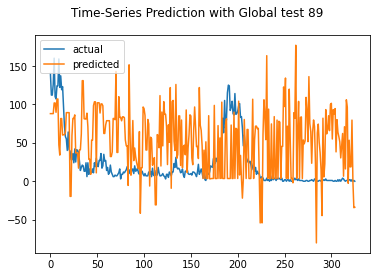

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 57.861
Test RMSE: 67.385
Test sMAPE: 135.187
Test R Squared: -3.179
{'mae': 57.86057152046016, 'rmse': 67.38525323013164, 'smape': 135.18741505514166, 'r2': -3.179421242394911}


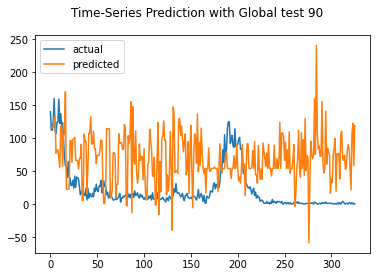

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 47.299
Test RMSE: 57.681
Test sMAPE: 131.970
Test R Squared: -2.062
{'mae': 47.2989794532397, 'rmse': 57.68070224432613, 'smape': 131.97036725684646, 'r2': -2.0622983086891247}


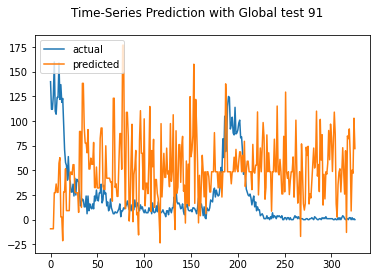

Test MAE: 59.452
Test RMSE: 66.553
Test sMAPE: 146.120
Test R Squared: -3.077
{'mae': 59.45154196535883, 'rmse': 66.55305043419169, 'smape': 146.11967048863886, 'r2': -3.0768276160312835}


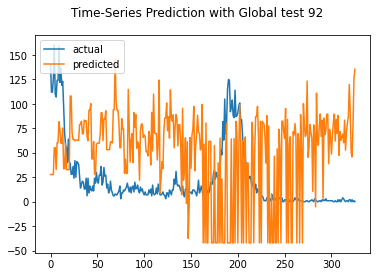

Test MAE: 54.182
Test RMSE: 64.998
Test sMAPE: 143.266
Test R Squared: -2.889
{'mae': 54.18198110647728, 'rmse': 64.99793625930891, 'smape': 143.26598631626072, 'r2': -2.8885308738867117}


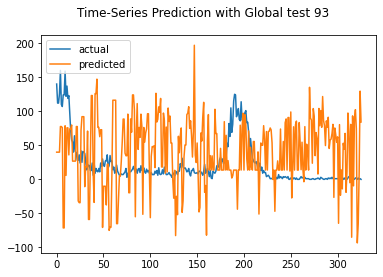

Test MAE: 98.974
Test RMSE: 117.060
Test sMAPE: 163.271
Test R Squared: -11.613
{'mae': 98.97390171940341, 'rmse': 117.06028397952589, 'smape': 163.27059471491668, 'r2': -11.612627308044265}


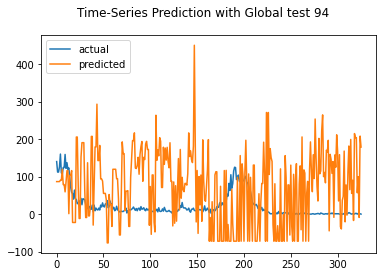

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 45.726
Test RMSE: 59.395
Test sMAPE: 133.265
Test R Squared: -2.247
{'mae': 45.72564385529676, 'rmse': 59.39546955526153, 'smape': 133.26485067726665, 'r2': -2.247080505224007}


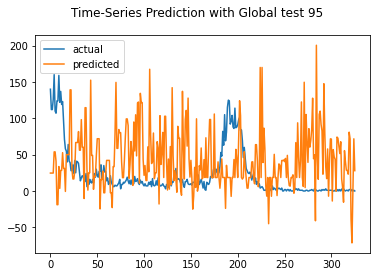

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 52.410
Test RMSE: 62.017
Test sMAPE: 131.640
Test R Squared: -2.540
{'mae': 52.409857290105585, 'rmse': 62.01708799517754, 'smape': 131.64023037518706, 'r2': -2.5400480469479008}


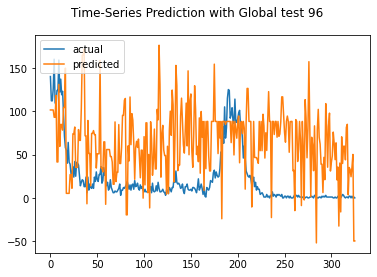

Test MAE: 59.838
Test RMSE: 72.983
Test sMAPE: 139.002
Test R Squared: -3.903
{'mae': 59.83846870083019, 'rmse': 72.98276884935962, 'smape': 139.0020923649521, 'r2': -3.90260707671837}


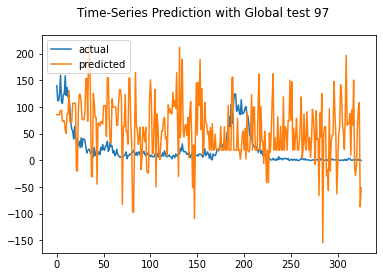

Test MAE: 57.450
Test RMSE: 82.053
Test sMAPE: 129.649
Test R Squared: -5.197
{'mae': 57.45049122634109, 'rmse': 82.05276406395868, 'smape': 129.64865333476016, 'r2': -5.196876587442591}


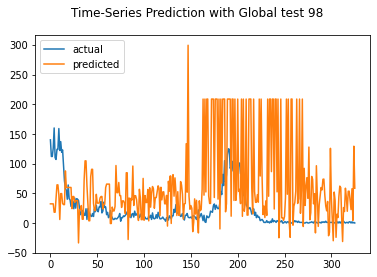

Test MAE: 84.450
Test RMSE: 98.953
Test sMAPE: 157.513
Test R Squared: -8.012
{'mae': 84.45043724994719, 'rmse': 98.95292592927156, 'smape': 157.51283943617173, 'r2': -8.012467194627966}


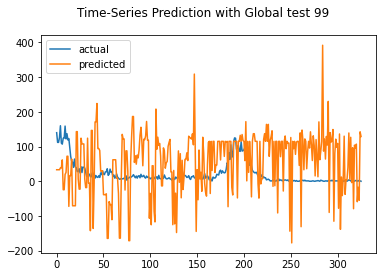

rmse : average=76.410, std=26.811
mae : average=61.345, std=18.717
smape : average=139.703, std=9.413
r2 : average=-5.035, std=5.062


([76.40988816072151, 26.81144941859229],
 [61.34494350630721, 18.717106234154524],
 [139.7025315090368, 9.413063470883186],
 [-5.035498050182493, 5.061538686098442])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
